<a href="https://colab.research.google.com/github/sridharnandigam/GestureRecognition/blob/master/gesture_rec_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Jun 24 11:57:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install gdown
!pip install tensorflow-gpu

     |████████████████████████████████| 516.2MB 31kB/s 


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

df = pd.read_csv('gesture_data.csv', header=None, names=column_names)
df.z_axis.replace(regex=True, inplace=True, to_replace=r';', value=r'')
df['z_axis'] = df.z_axis.astype(np.float64)
df.dropna(axis=0, how='any', inplace=True)

df['user_id'] = df.user_id.astype(int)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
print(df.head())
print("Shape", df.shape)

   user_id activity     timestamp    x_axis    y_axis    z_axis
0       30   waving  4.582675e+09 -0.353728  5.283476  7.901423
1       30   waving  4.588676e+09 -0.277715  5.296046  8.208766
2       30   waving  4.594678e+09 -0.277715  5.296046  8.208766
3       30   waving  4.607681e+09 -0.238512  5.258937  8.365580
4       30   waving  4.614681e+09 -0.201104  5.226916  8.395206
Shape (131205, 6)


In [6]:
new_df = df[['user_id', 'activity']]

df25 = new_df[new_df['user_id'] == 25]
df26 = new_df[new_df['user_id'] == 26]
df27 = new_df[new_df['user_id'] == 27]
df28 = new_df[new_df['user_id'] == 28]
df29 = new_df[new_df['user_id'] == 29]
df30 = new_df[new_df['user_id'] == 30]

df_list = [df25, df26, df27, df28, df29, df30]
collabels = [25, 26, 27, 28 , 29, 30]
rowlabels = ['waving', 'semicircle', 'outwardsL', 'outwardsR', 'dab', 'lineV', 'lineH', 'xmark', 'circle', 'towards', 'drinking']
epic_df = pd.DataFrame(index = rowlabels, columns = collabels)

currindex = collabels[0]
for d in df_list:
  for index, value in d.activity.value_counts().items():
    epic_df.loc[index, currindex] = value
  currindex += 1

#Prints out data distribution per user for each activity. Helps to figure out training, testing split
print(epic_df)


              25    26    27    28    29    30
waving      2746  3935   548  2316  2496  9272
semicircle   705  1996   932  1566  3801  4011
outwardsL   2233  1857  1705  1543  2030  2606
outwardsR   1356  1966  1109  1771  2015  2464
dab          NaN  1749  1741  1608  1389  2305
lineV        NaN  1493  3066  2253  2327  2260
lineH       1282  1923  2070  1796  2121  2176
xmark       1249  1935  1950  1900  2268  2011
circle      3786  1514  1479  2005  1356  1936
towards      NaN  2935  2897  1768  1740  1723
drinking     NaN  1763  1265  1855  1628  1704


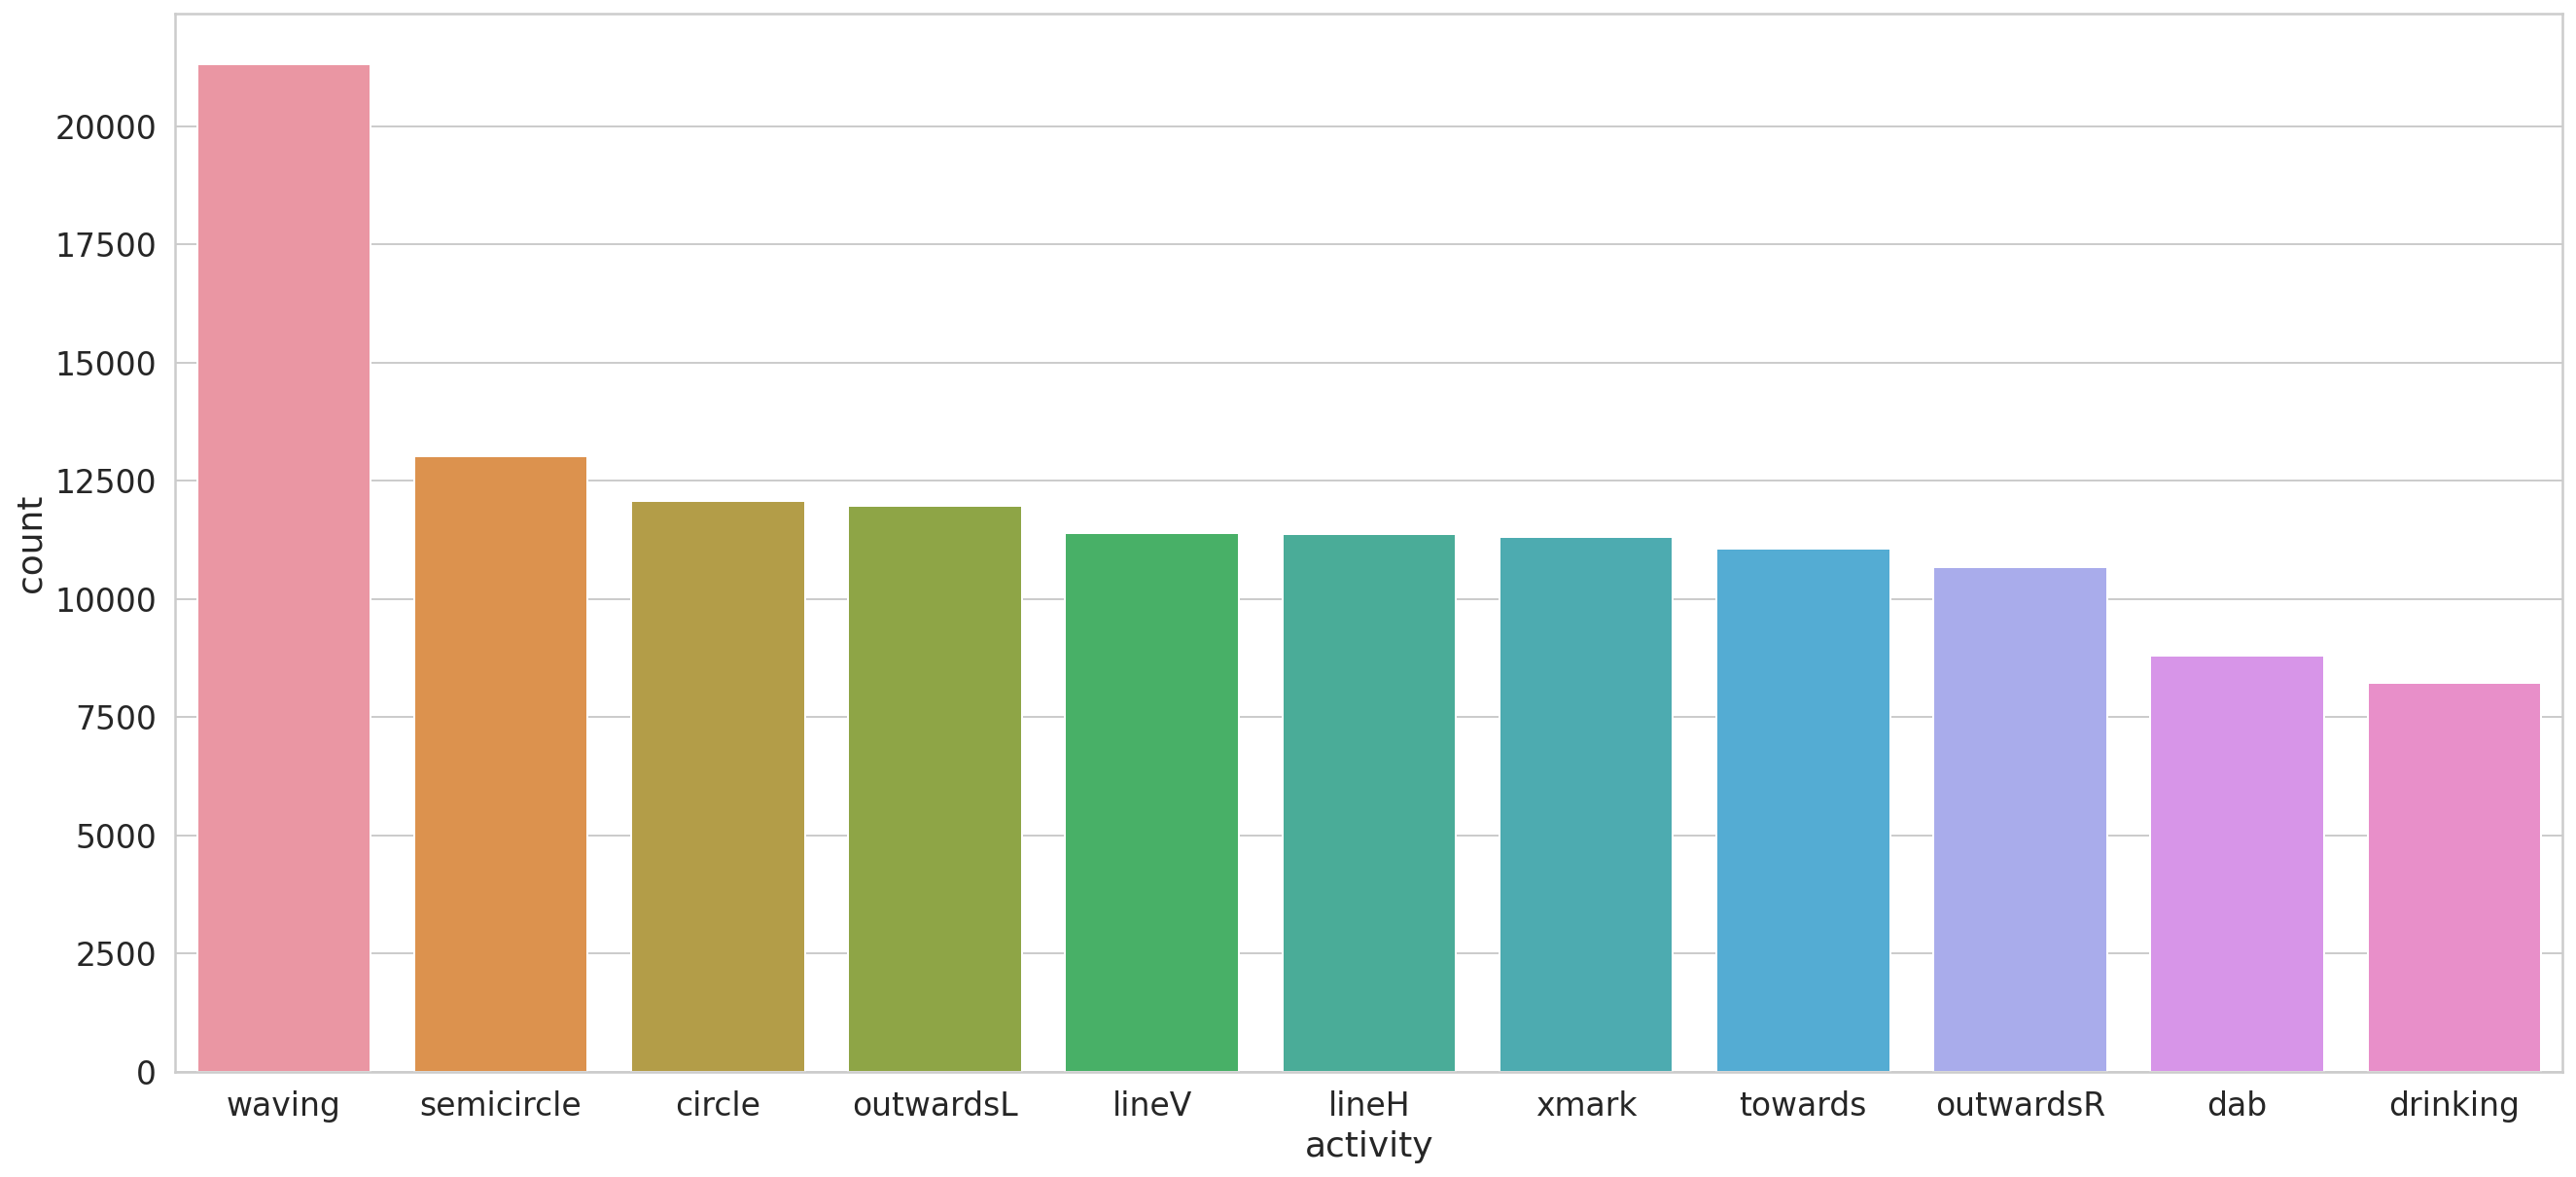

In [ ]:
sns.countplot(x = 'activity',
              data = df,
              order = df.activity.value_counts().index);

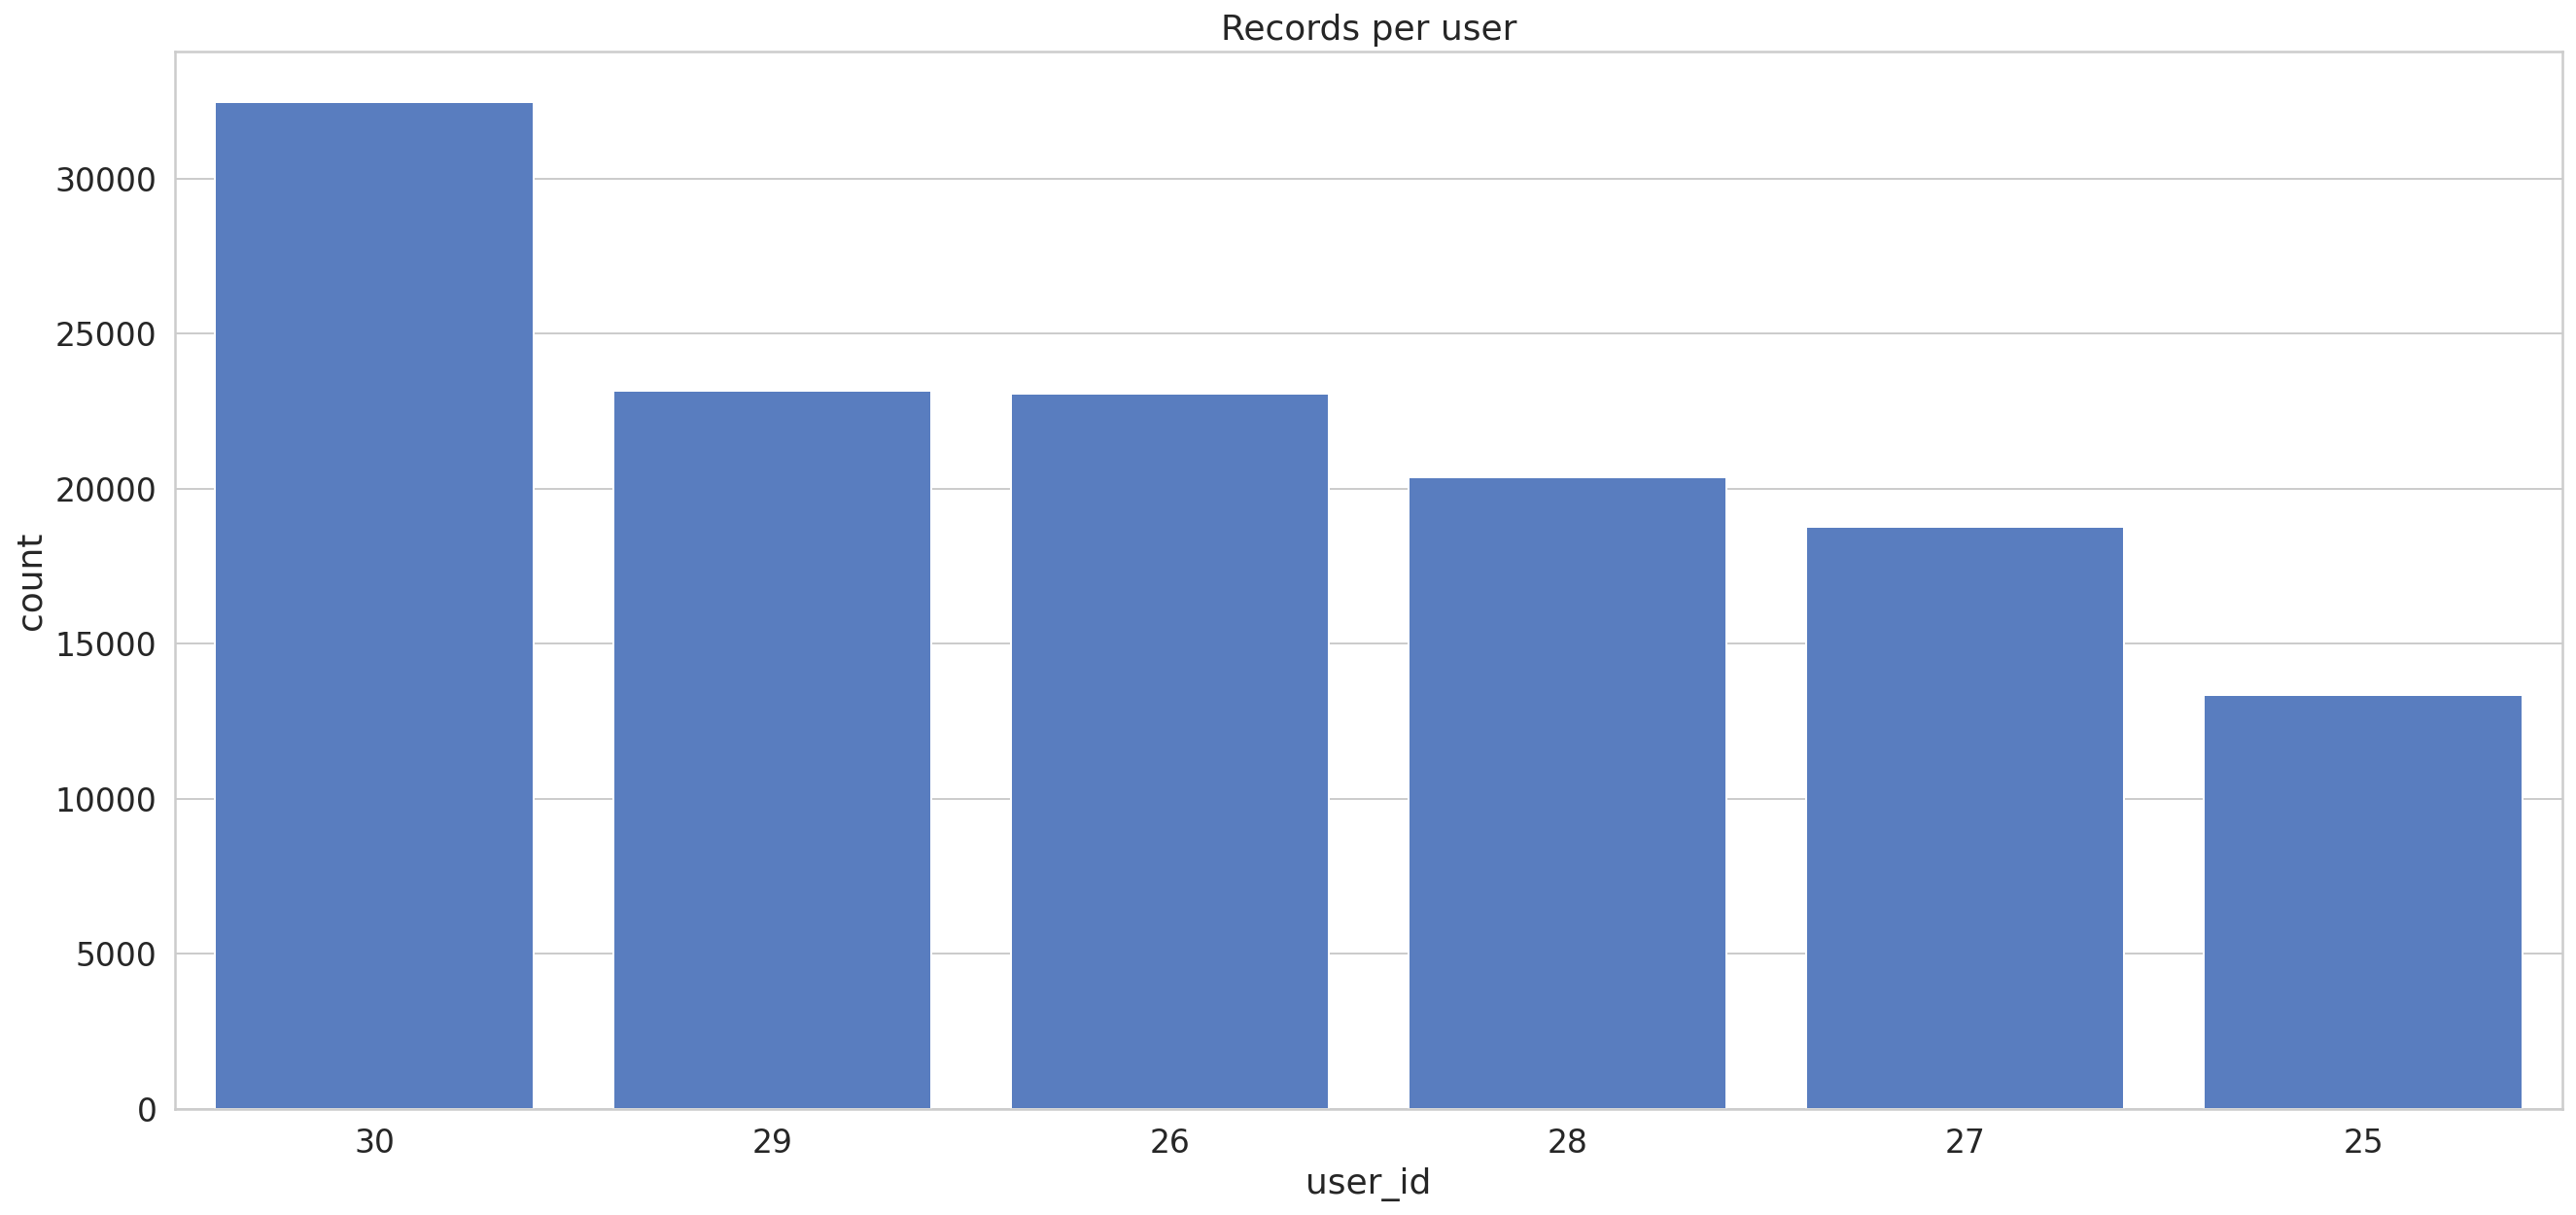

In [ ]:
sns.countplot(x = 'user_id',
              data = df,
              palette=[sns.color_palette()[0]],
              order = df.user_id.value_counts().index);
plt.title("Records per user");

In [ ]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x_axis', 'y_axis', 'z_axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

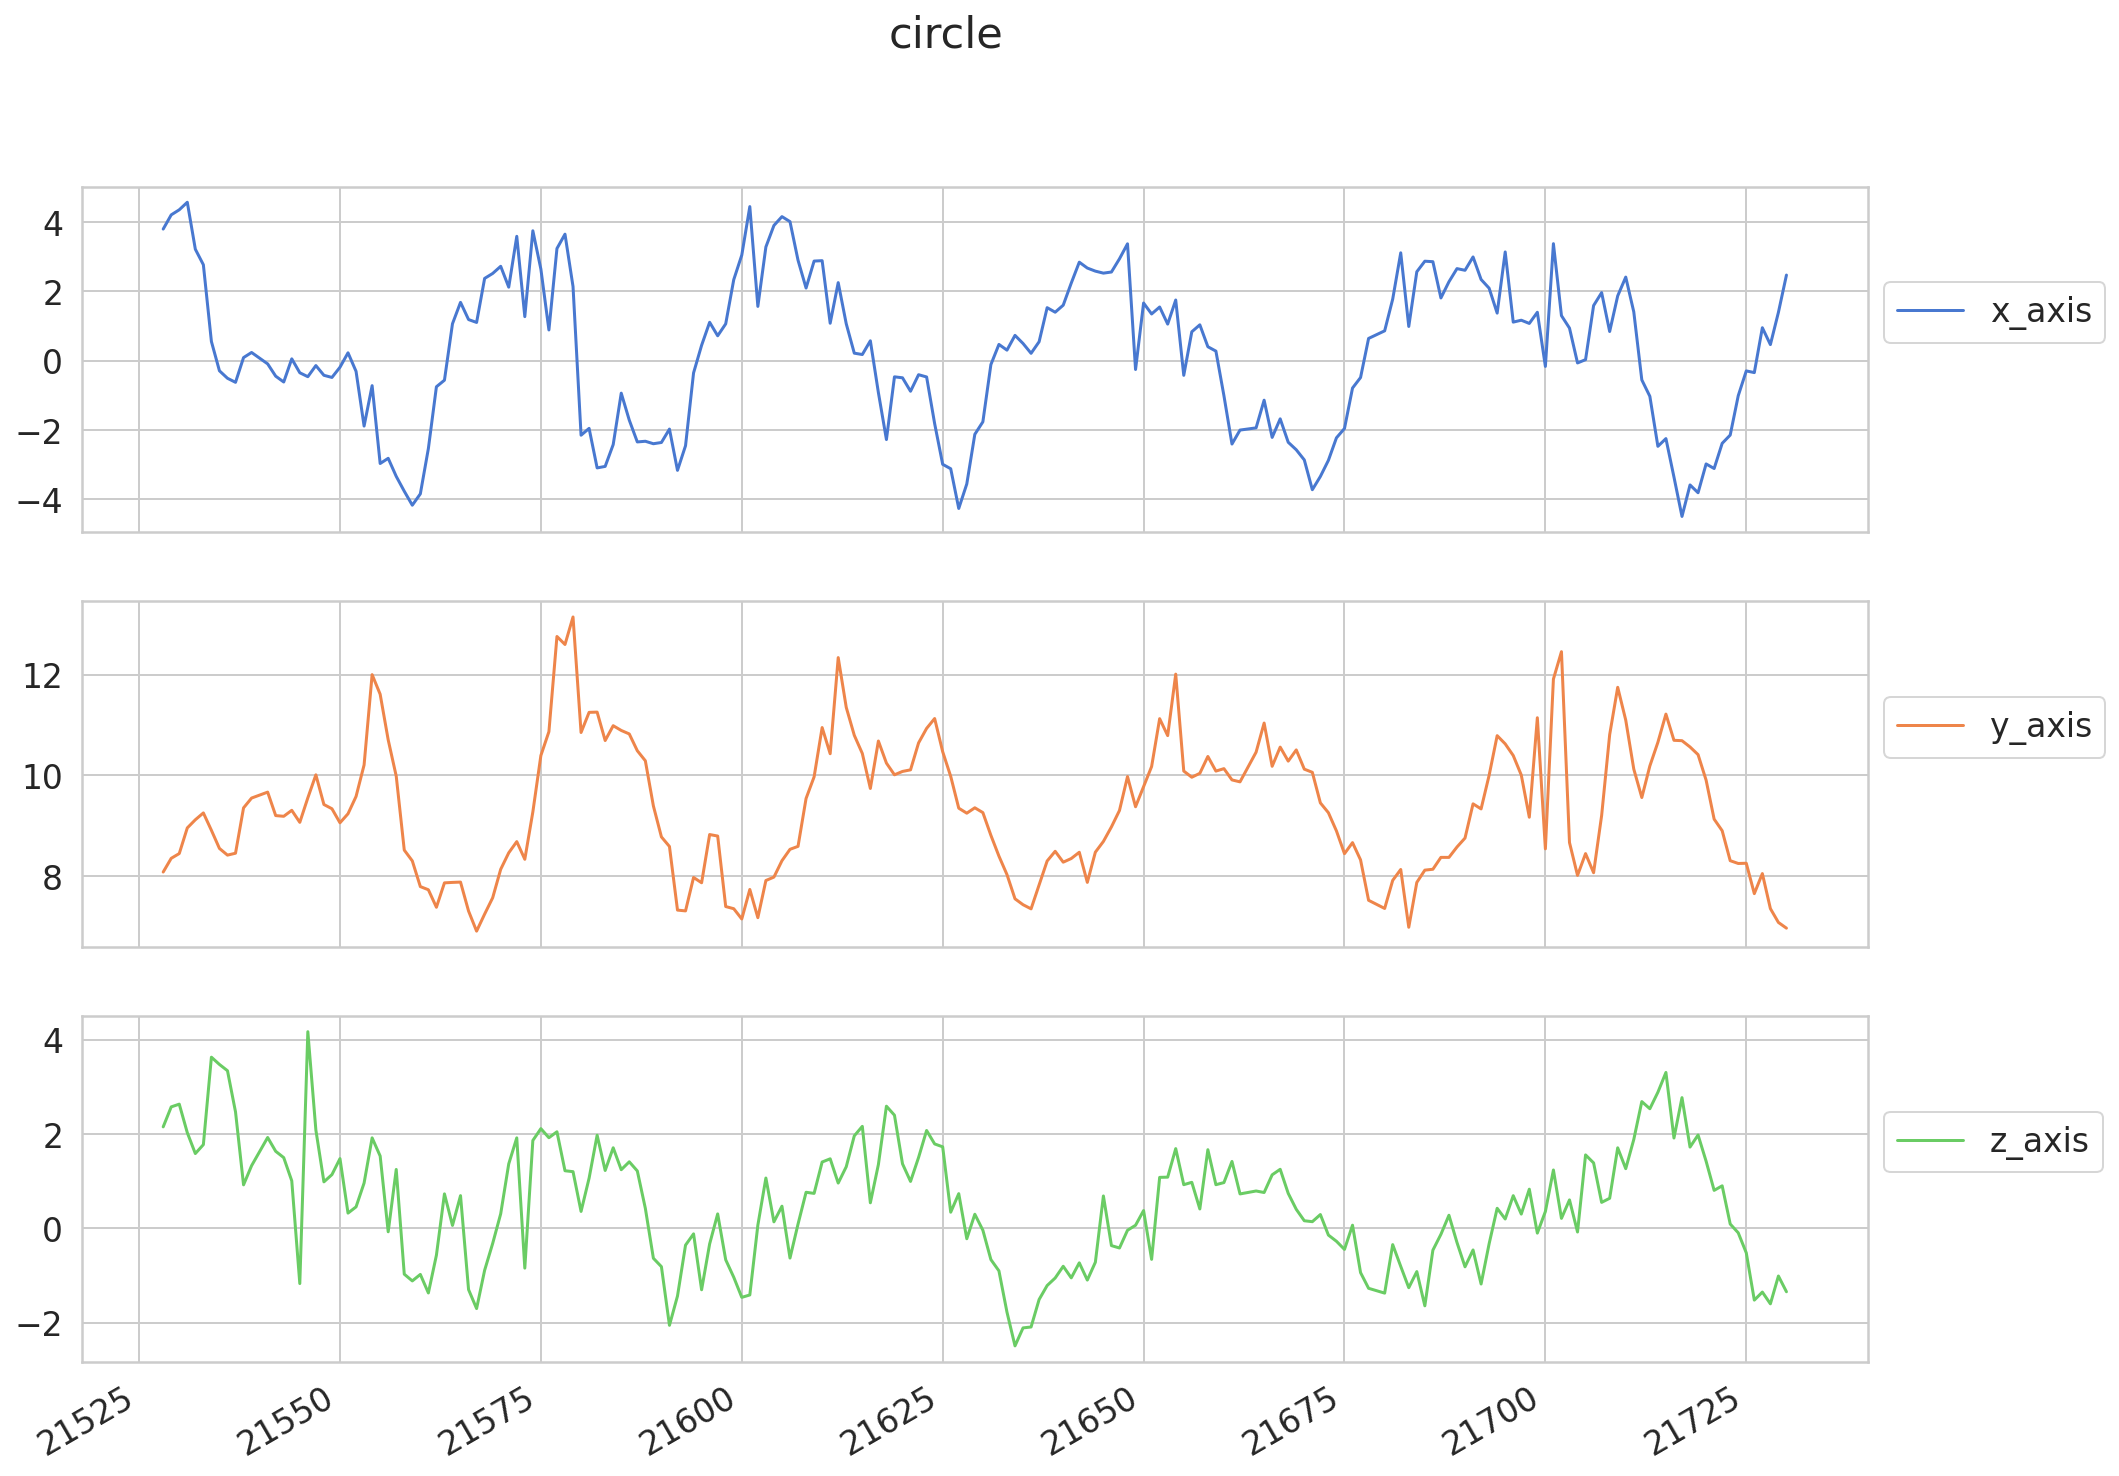

In [ ]:
plot_activity("circle", df);

In [7]:
df['user_id'] = df['user_id'].astype(int)
df_train = df[df['user_id'] > 26]
df_test = df[df['user_id'] <= 26]

In [ ]:
df_test.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
14780,26,waving,2.625991e+09,0.391435,4.025677,8.900661
14781,26,waving,2.668957e+09,0.390837,3.978394,8.961112
14782,26,waving,2.717996e+09,0.427945,3.885323,8.975475
14783,26,waving,2.768635e+09,0.330583,3.975102,8.941061
14784,26,waving,2.835383e+09,0.287890,3.983780,8.927295


In [8]:
from sklearn.preprocessing import RobustScaler

scale_columns = ['x_axis', 'y_axis', 'z_axis']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [9]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']], 
    df_train.activity, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']], 
    df_test.activity, 
    TIME_STEPS, 
    STEP
)

In [ ]:
print(X_train.shape, y_train.shape)

(2365, 200, 3) (2365, 1)


In [10]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [ ]:
print(X_train.shape, y_train.shape)

(2365, 200, 3) (2365, 11)


In [11]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='tanh'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


In [12]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_test, y_test),
    shuffle=True
)
#validation_split=0.1

Epoch 1/30
37/37 [==============================] - 5s 124ms/step - loss: 1.6322 - acc: 0.4063 - val_loss: 1.6023 - val_acc: 0.4625
Epoch 2/30
37/37 [==============================] - 4s 95ms/step - loss: 1.0583 - acc: 0.5856 - val_loss: 1.2041 - val_acc: 0.5651
Epoch 3/30
37/37 [==============================] - 3s 91ms/step - loss: 0.8294 - acc: 0.6689 - val_loss: 1.7903 - val_acc: 0.4724
Epoch 4/30
37/37 [==============================] - 3s 88ms/step - loss: 0.6391 - acc: 0.7188 - val_loss: 0.8030 - val_acc: 0.7174
Epoch 5/30
37/37 [==============================] - 3s 88ms/step - loss: 0.5838 - acc: 0.7518 - val_loss: 0.8740 - val_acc: 0.6446
Epoch 6/30
37/37 [==============================] - 3s 87ms/step - loss: 0.5840 - acc: 0.7767 - val_loss: 0.9105 - val_acc: 0.7428
Epoch 7/30
37/37 [==============================] - 3s 85ms/step - loss: 0.4980 - acc: 0.8216 - val_loss: 0.8711 - val_acc: 0.7616
Epoch 8/30
37/37 [==============================] - 3s 85ms/step - loss: 0.5578 - 

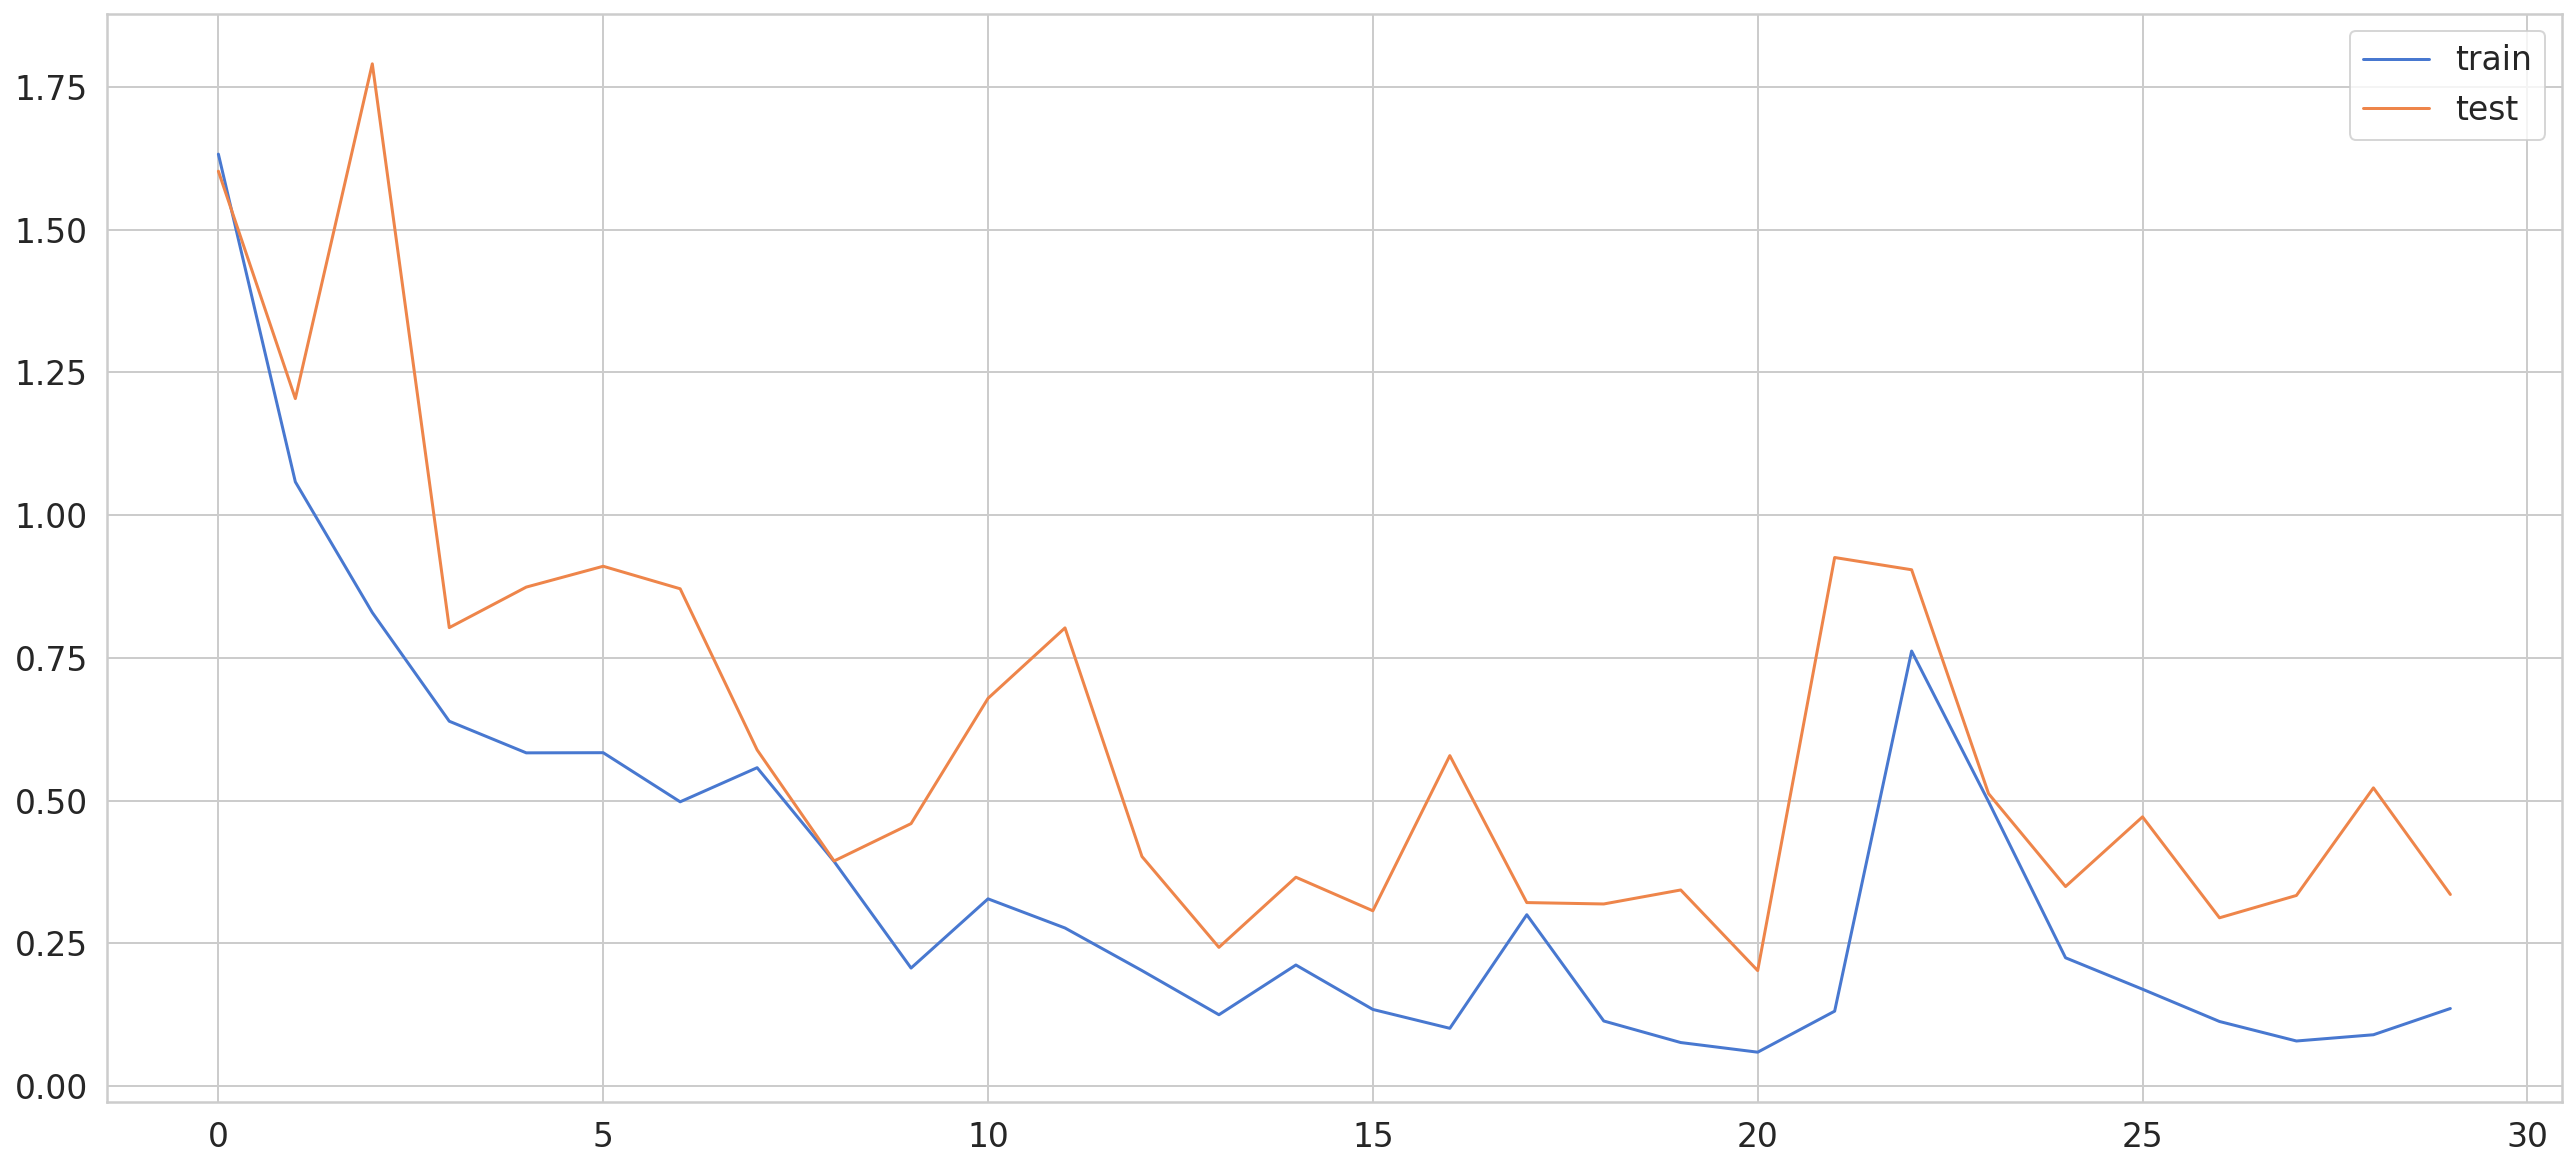

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [14]:
model.evaluate(X_test, y_test)

29/29 [==============================] - 1s 33ms/step - loss: 0.3357 - acc: 0.9272


[0.3357270061969757, 0.9271523356437683]

In [15]:
y_pred = model.predict(X_test)

In [19]:
from sklearn.metrics import classification_report

print(classification_report(enc.inverse_transform(y_test), enc.inverse_transform(y_pred), enc.categories_[0]))

              precision    recall  f1-score   support

      circle       0.91      0.98      0.94       132
         dab       0.94      1.00      0.97        44
    drinking       1.00      0.88      0.94        42
       lineH       0.94      0.94      0.94        81
       lineV       0.74      0.92      0.82        37
   outwardsL       0.93      0.82      0.87       102
   outwardsR       0.96      0.96      0.96        83
  semicircle       0.82      0.97      0.89        67
     towards       0.98      0.69      0.81        74
      waving       1.00      0.98      0.99       165
       xmark       0.90      1.00      0.95        79

    accuracy                           0.93       906
   macro avg       0.92      0.92      0.92       906
weighted avg       0.93      0.93      0.93       906



In [ ]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred, labels=class_names)
  fig, ax = plt.subplots(figsize=(10, 10)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(230, 30, n=9),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_title('Confusion Matrix')
  ax.set_xticklabels(class_names, rotation = 45)
  ax.set_yticklabels(class_names, rotation=0)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

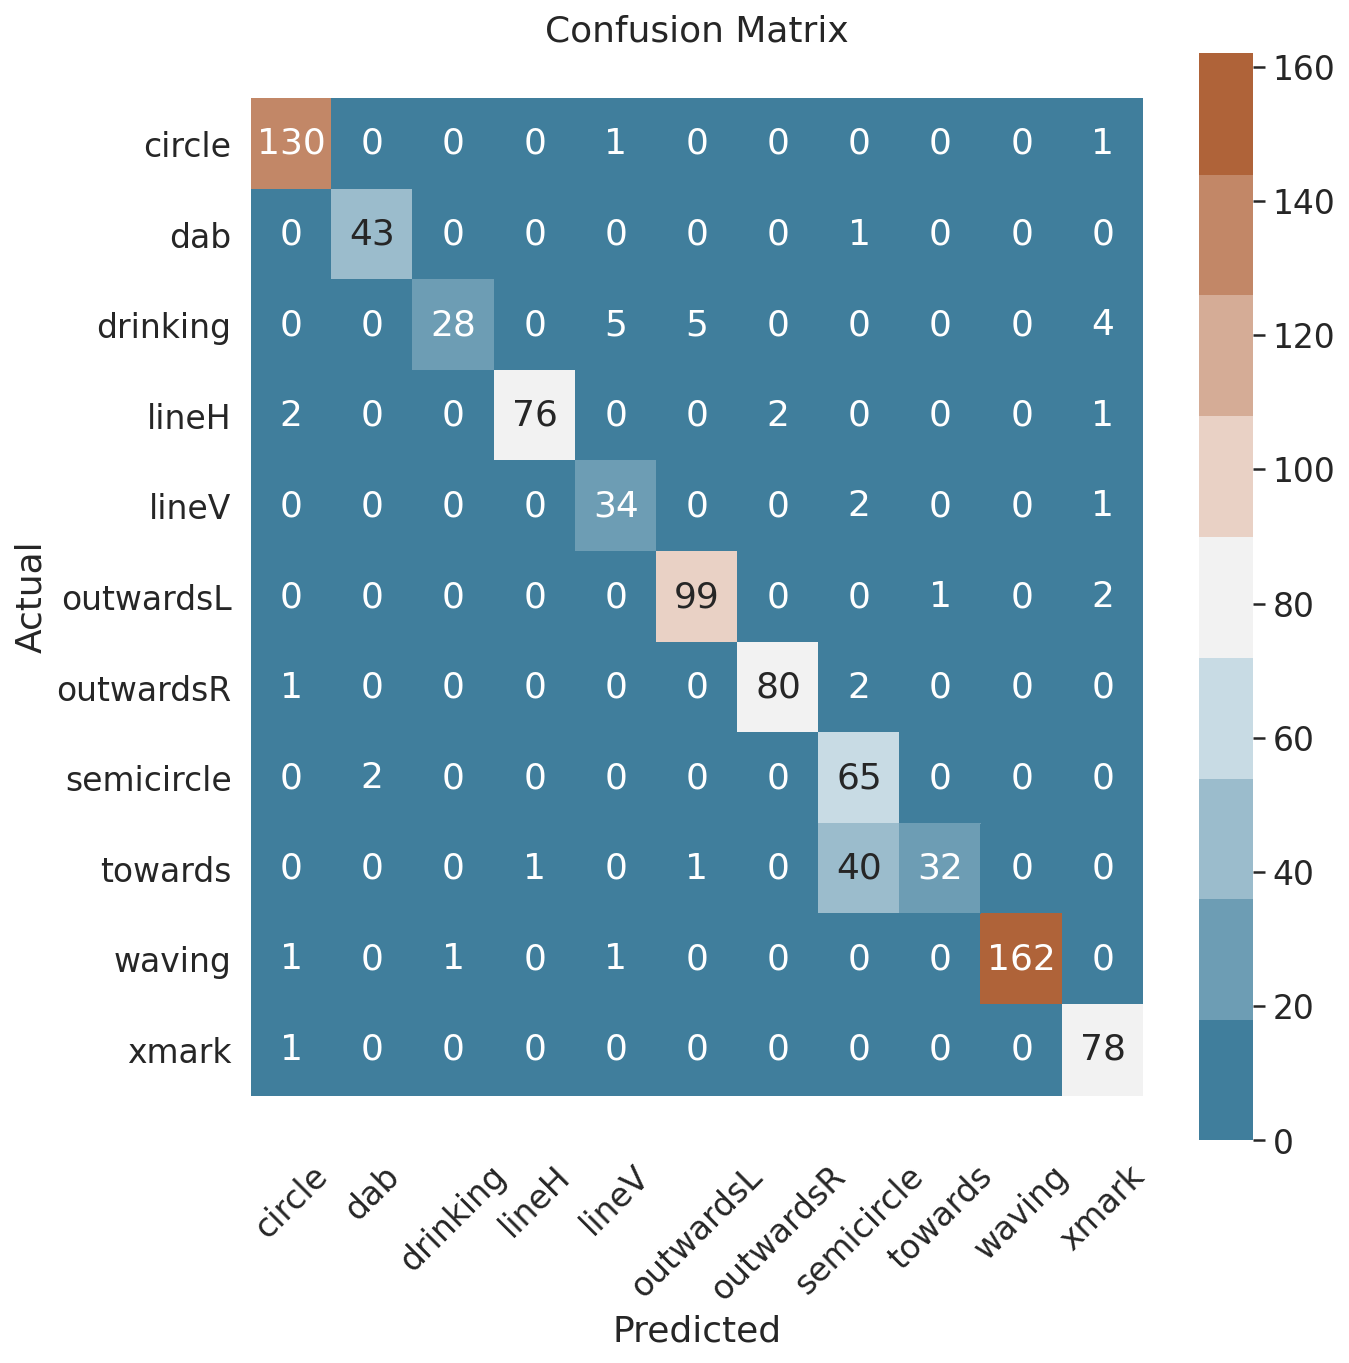

In [ ]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)